In [1]:
import requests
r = requests.get('https://ipinfo.io')
region = r.json()['region']
r.json()

{'city': 'The Dalles',
 'country': 'US',
 'hostname': '185.207.233.35.bc.googleusercontent.com',
 'ip': '35.233.207.185',
 'loc': '45.5946,-121.1787',
 'org': 'AS15169 Google LLC',
 'postal': '97058',
 'readme': 'https://ipinfo.io/missingauth',
 'region': 'Oregon',
 'timezone': 'America/Los_Angeles'}

In [2]:
!pip install pathy -q
!pip install wandb -q
!pip install -q git+https://github.com/huggingface/transformers.git timm
!pip install -q pytorch-lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=1000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP



### Sample local config
args = parser.parse_args('''
sketch_run
--train_dataset rgb_ppt/train
--test_dataset rgb_ppt/val
-c
-s GCS
--bucket_name artificial_graphics
'''.split())

In [4]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/artificial_graphics' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading data from Google Cloud Storage
Storage path: gs://artificial_graphics/


## With Pytorch - we have to copy the data over


In [5]:
import subprocess
!mkdir data
!mkdir saved_models
subprocess.call(["gsutil", "-m", "cp", "-r", f"{TRAIN_DATA_PATHS[0]}", "data"])
subprocess.call(["gsutil", "-m", "cp", "-r", f"{TEST_DATA_PATHS[0]}", "data"])

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘saved_models’: File exists


0

## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [6]:
DATA_BASE = 'data/'

In [7]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [8]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=1.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 24000
Number of validation examples: 120


Image n°19568


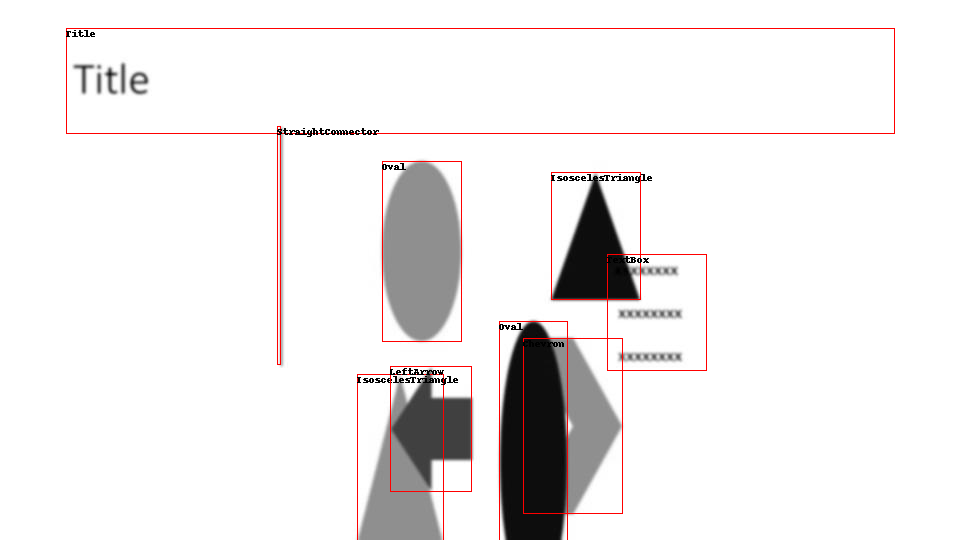

In [10]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='black')

image

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers = 3)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2, num_workers = 1)
t_it = iter(train_dataloader)
batch = next(t_it)

In [12]:
# batch = next(t_it)
# import matplotlib.pyplot as plt
# for i in range(0,4):
#     plt.imshow(batch['pixel_values'][i].permute(1,2,0))
#     plt.show()

In [13]:
import lib
import lib.DETR

In [14]:
!git pull

Already up to date.


In [15]:
from importlib import reload
reload(lib)
reload(lib.DETR)

<module 'lib.DETR' from '/content/artificial_graphics/lib/DETR.py'>

In [16]:
import wandb
wandb.init(project="artificial_graphics_v3")
wandb.run.name = args.run_name

wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


In [17]:
import pytorch_lightning as pl
from transformers import DetrConfig
from lib.DETR import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
         state_dict = model.state_dict()
         # Remove class weights
         del state_dict["class_labels_classifier.weight"]
         del state_dict["class_labels_classifier.bias"]
         # define new model with custom class classifier
         config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
         model = DetrForObjectDetection(config)
         model.load_state_dict(state_dict, strict=False)
         self.model = model

         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay
         self.save_interval = 1000

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        log_dict = {"train_" + k: v.item() for k,v in loss_dict.items()}   
        log_dict['train_loss'] = loss   
        # logs metrics for each training_step,
        # and the average across the epoch
        # self.log("training_loss", loss)
        # for k,v in loss_dict.items():
        #   self.log("train_" + k, v.item())
        wandb.log(log_dict, step=self.global_step)
        if self.global_step % self.save_interval == 0:
          self.save()
        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx) 
        log_dict = {"validation_" + k: v.item() for k,v in loss_dict.items()}
        log_dict['validation_loss'] = loss    
        # self.log("validation_loss", loss)
        # for k,v in loss_dict.items():
        #   self.log("validation_" + k, v.item())
        wandb.log(log_dict, step=self.global_step)
        
        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

     def save(self):
        torch.save(self.model.state_dict(), f'saved_models/{args.run_name}')
        subprocess.call(["gsutil", "-m", "cp", "-r", "saved_models/", str(STORAGE_PATH),])

     def load(self, name=None):
        # calls the latest over from gcp
        name = args.run_name if name == None else name
        subprocess.call(["gsutil", "-m", "cp", str(STORAGE_PATH/f'saved_models/{name}'), "saved_models/", ])
        state_dict = torch.load(f'saved_models/{name}')
        self.model.load_state_dict(state_dict)

In [18]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, max_steps=20000, gradient_clip_val=0.1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.core.lightning:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.045   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [19]:
model.load()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrTimmConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (act2): ReLU(inplace=True)
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3)

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.4):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
pixel_values, target = val_dataset[18]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)


torch.Size([1, 3, 750, 1333])


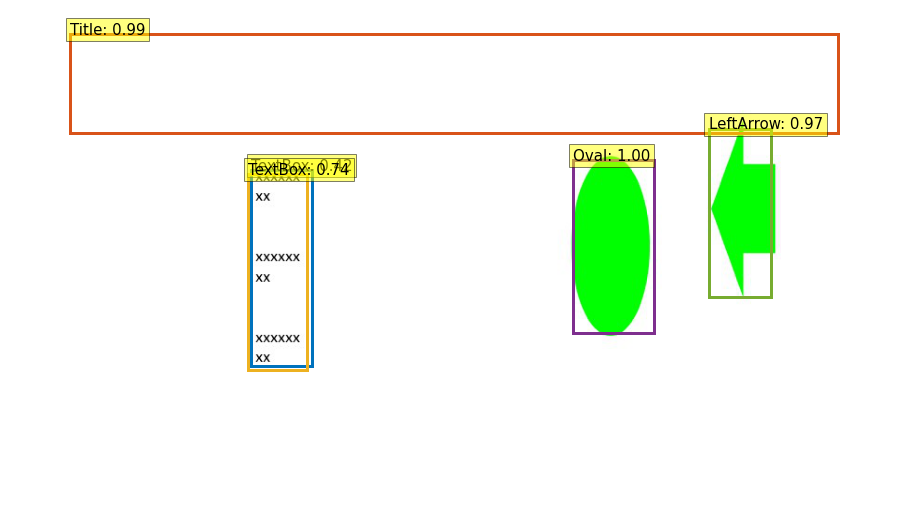

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/val', image['file_name']))

visualize_predictions(image, outputs)

In [ ]:
target['image_id']

tensor([18])